# Importing Necessary Libraries

In [120]:
import re
import numpy as np
import modin.pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import nltk
from nltk.tokenize import RegexpTokenizer
import opendatasets as od
import string
from wordcloud import WordCloud
from distributed import Client
client = Client()

Perhaps you already have a cluster running?
Hosting the HTTP server on port 53976 instead


# Downloading Word Lists

In [87]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Downloading Dataset

In [88]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140")
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

Skipping, found downloaded files in ".\sentiment140" (use force=True to force download)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Exploratory Data Analysis

In [89]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  ----------------  ----- 
 0   target  1600000 non-null  int64
 1   ids     1600000 non-null  int64
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: object(4), int64(2)
memory usage: 73.2 MB


In [90]:
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [91]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [92]:
df.target.unique()

array([0, 4], dtype=int64)

# Distribution Of Data Count-Plot

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

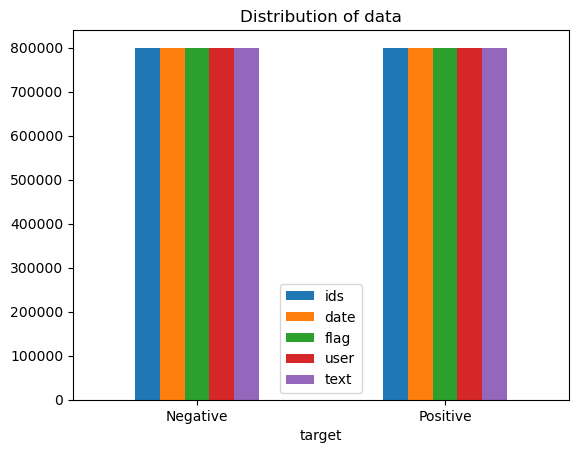

In [93]:
df.groupby("target").count().plot(kind='bar', title='Distribution of data').set_xticklabels(['Negative','Positive'], rotation=0)

# Data Augumentataion

In [94]:
dataset=df[['text','target']]
dataset['target'] = dataset['target'].replace(4,1)

In [95]:
dataset

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [96]:
dataset.target.unique()

array([0, 1], dtype=int64)

# Data Cleaning

## &nbsp;&nbsp;&nbsp;&nbsp;Converting to Lower Case

In [97]:
dataset['text']=dataset['text'].str.lower()
dataset

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,just woke up. having no school is the best fee...,1
1599996,thewdb.com - very cool to hear old walt interv...,1
1599997,are you ready for your mojo makeover? ask me f...,1
1599998,happy 38th birthday to my boo of alll time!!! ...,1


In [98]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s',
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning StopWords

In [99]:
def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in set(stopwords)])
dataset['text'] = dataset['text'].apply(lambda text: clean_stopwords(text))
dataset.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,upset can't update facebook texting it... migh...,0
2,@kenichan dived many times ball. managed save ...,0
3,whole body feels itchy like fire,0
4,"@nationwideclass no, it's not behaving all. i'...",0


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Punctuations

In [100]:
def clean_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))
dataset['text']= dataset['text'].apply(lambda x: clean_punctuations(x))
dataset

,text,target
0,switchfoot httptwitpiccom2y1zl awww thats bum...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no its not behaving all im mad...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,thewdbcom cool hear old walt interviews â« h...,1
1599997,ready mojo makeover ask details,1
1599998,happy 38th birthday boo alll time tupac amaru ...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Repeating Characters

In [101]:
def clean_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: clean_repeating_char(x))
dataset

,text,target
0,switchfoot httptwitpiccom21zl awww thats bumm...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no its not behaving all im mad...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,thewdbcom cool hear old walt interviews â« h...,1
1599997,ready mojo makeover ask details,1
1599998,happy 38th birthday boo alll time tupac amaru ...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning URLs

In [102]:
def clean_url(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: clean_url(x))
dataset

,text,target
0,switchfoot httptwitpiccom21zl a s bummer shou...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no its not behaving all im mad...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,thewdbcom cool hear old walt interviews â« h...,1
1599997,ready mojo makeover ask details,1
1599998,happy 38th birthday boo alll time tupac amaru ...,1


## &nbsp;&nbsp;&nbsp;&nbsp; Cleaning Numbers

In [103]:
def clean_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: clean_numbers(x))
dataset

,text,target
0,switchfoot httptwitpiccomzl a s bummer should...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save r...,0
3,whole body feels itchy like fire,0
4,nationwideclass no its not behaving all im mad...,0
...,...,...
1599995,woke up no school best feeling ever,1
1599996,thewdbcom cool hear old walt interviews â« h...,1
1599997,ready mojo makeover ask details,1
1599998,happy th birthday boo alll time tupac amaru sh...,1


In [104]:
dataset['text'] = dataset['text'].apply(RegexpTokenizer(r'\w+').tokenize)
dataset

,text,target
0,"[switchfoot, httptwitpiccomzl, a, s, bummer, s...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[kenichan, dived, many, times, ball, managed, ...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[nationwideclass, no, its, not, behaving, all,...",0
...,...,...
1599995,"[woke, up, no, school, best, feeling, ever]",1
1599996,"[thewdbcom, cool, hear, old, walt, interviews,...",1
1599997,"[ready, mojo, makeover, ask, details]",1
1599998,"[happy, th, birthday, boo, alll, time, tupac, ...",1


In [105]:
def stem_text(data):
    for word in data: nltk.PorterStemmer().stem(word)
    return data
dataset['text']= dataset['text'].apply(lambda x: stem_text(x))
dataset

,text,target
0,"[switchfoot, httptwitpiccomzl, a, s, bummer, s...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[kenichan, dived, many, times, ball, managed, ...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[nationwideclass, no, its, not, behaving, all,...",0
...,...,...
1599995,"[woke, up, no, school, best, feeling, ever]",1
1599996,"[thewdbcom, cool, hear, old, walt, interviews,...",1
1599997,"[ready, mojo, makeover, ask, details]",1
1599998,"[happy, th, birthday, boo, alll, time, tupac, ...",1


In [106]:
def lemmatize_text(data):
    for word in data: WordNetLemmatizer().lemmatize(word)
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatize_text(x))
dataset

,text,target
0,"[switchfoot, httptwitpiccomzl, a, s, bummer, s...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[kenichan, dived, many, times, ball, managed, ...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[nationwideclass, no, its, not, behaving, all,...",0
...,...,...
1599995,"[woke, up, no, school, best, feeling, ever]",1
1599996,"[thewdbcom, cool, hear, old, walt, interviews,...",1
1599997,"[ready, mojo, makeover, ask, details]",1
1599998,"[happy, th, birthday, boo, alll, time, tupac, ...",1


In [107]:
X=dataset.text
y=dataset.target

In [108]:
X=X.apply(lambda x: " ".join(x))
X

0          switchfoot httptwitpiccomzl a s bummer shoulda...
1          upset cant update facebook texting it might cr...
2          kenichan dived many times ball managed save re...
3                           whole body feels itchy like fire
4          nationwideclass no its not behaving all im mad...
                                 ...                        
1599995                  woke up no school best feeling ever
1599996    thewdbcom cool hear old walt interviews â http...
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object

In [109]:
dataset[dataset.target==0].count()

text      800000
target    800000
dtype: int64

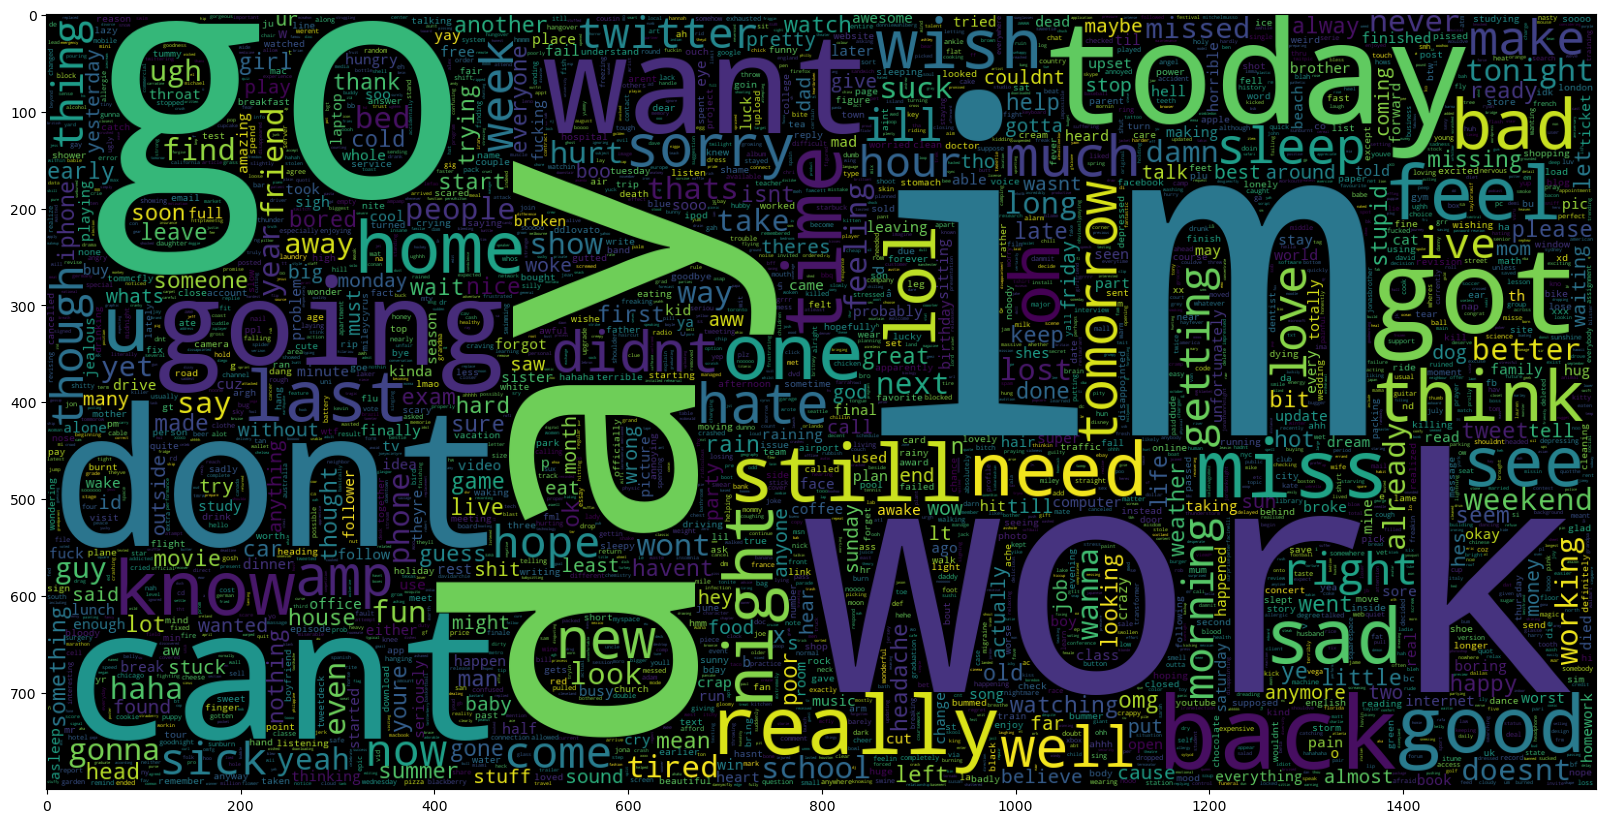

In [110]:
data_neg = dataset[dataset.target==0].text
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 10000 , width = 1600 , height = 800,collocations=False).generate(" ".join(" ".join(i) for i in data_neg))
plt.imshow(wc)

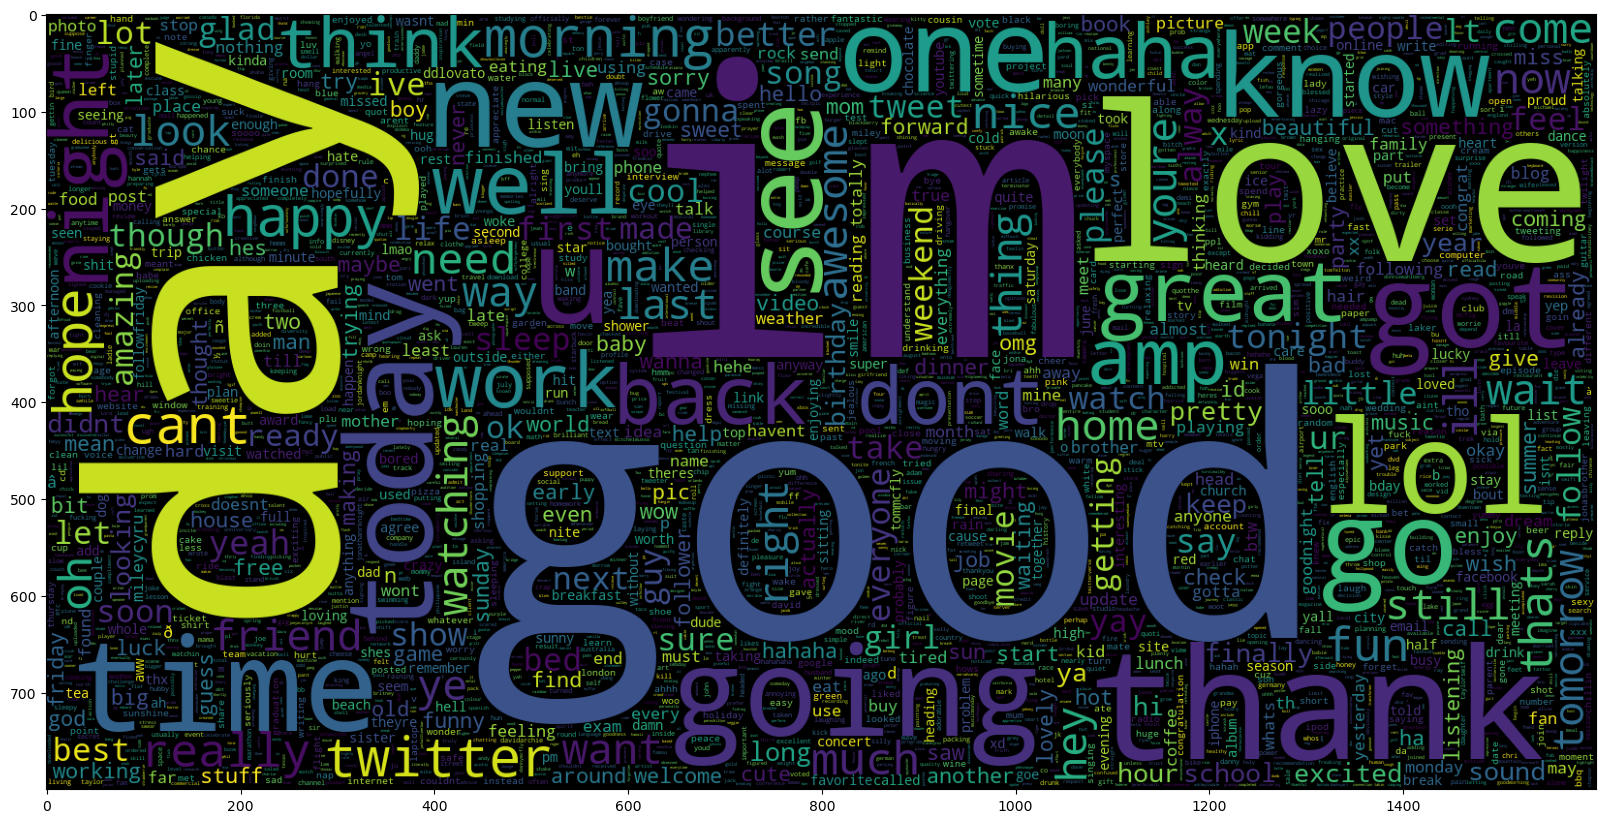

In [111]:
data_neg = dataset[dataset.target==1].text
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 10000 , width = 1600 , height = 800,collocations=False).generate(" ".join(" ".join(i) for i in data_neg))
plt.imshow(wc)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)

In [113]:
X_train

504328     great meet dominiqueb knitpurl but missed seei...
196809                                           tummy hurts
187559     im not adorable looked up ps httpbitlyozq try ...
646526              eastermoon ooooooooooooh thats different
1428077    playing new toy much batter dead time recharge...
                                 ...                        
259178          songs middle change doesnt want born arghhhh
1414414                             officialnjonas good luck
131932                        proudgamertweet rather average
671155     pickin misstinayao waitin sadittysash hurry up...
121958          home studying maths wooot im going fail shit
Name: text, Length: 1520000, dtype: object

In [114]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [115]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [116]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    sns.heatmap(cf_matrix, annot = np.asarray([f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]).reshape(2,2), cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39999
           1       0.78      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



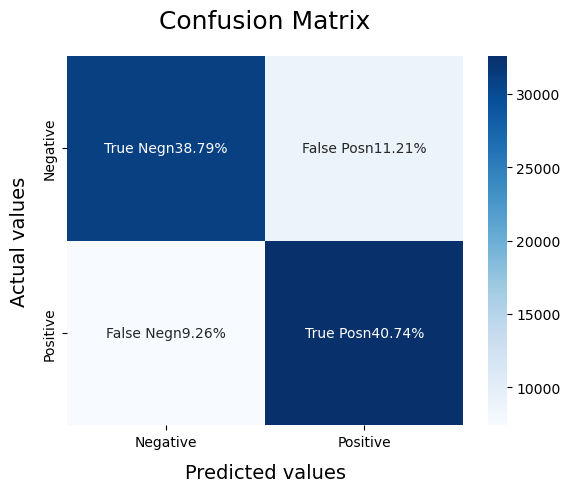

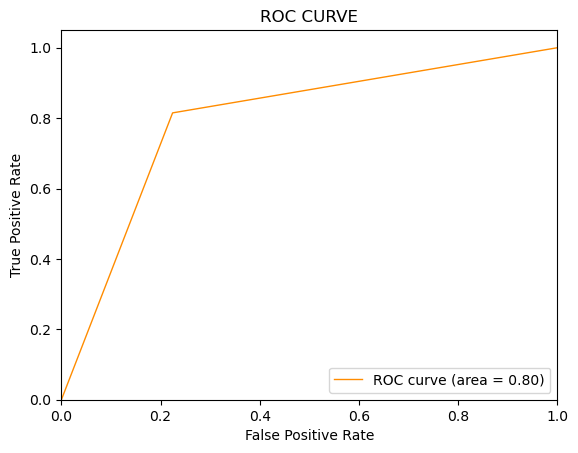

In [117]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39999
           1       0.80      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



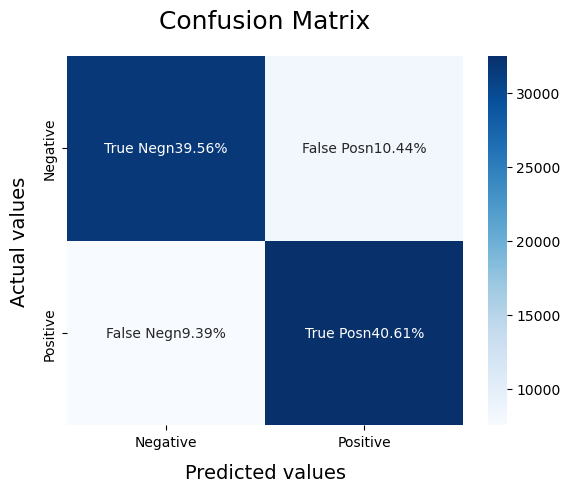

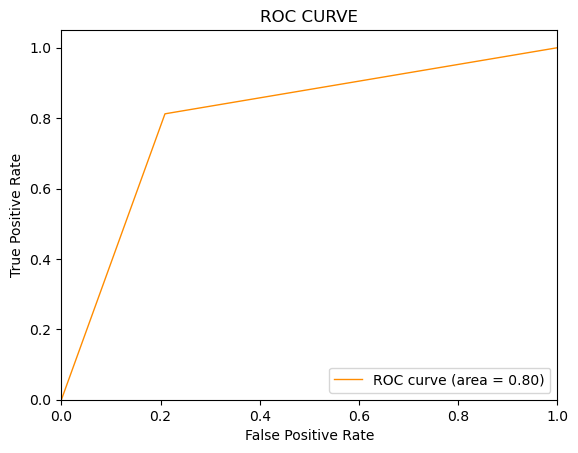

In [118]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39999
           1       0.81      0.83      0.82     40001

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



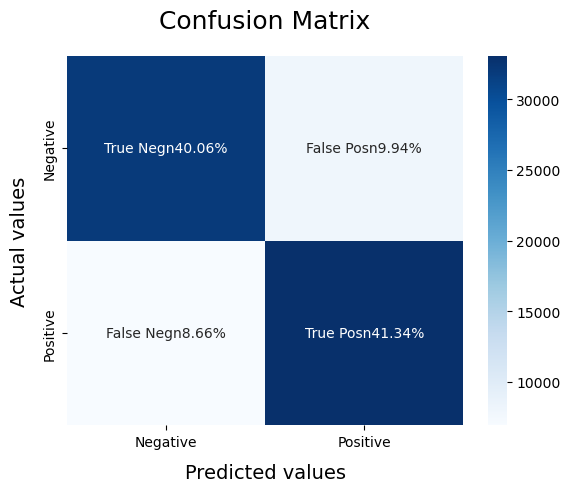

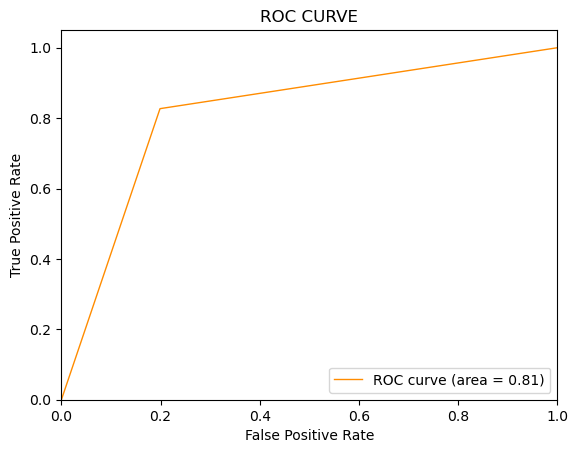

2023-02-06 11:29:41,631 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:53054', name: 0, status: running, memory: 1, processing: 0>
2023-02-06 11:29:41,864 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:53121', name: 2, status: running, memory: 31, processing: 0>
2023-02-06 11:29:41,868 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:51802', name: 1, status: running, memory: 41, processing: 0>
2023-02-06 11:29:41,996 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:53060', name: 1, status: running, memory: 0, processing: 1>
2023-02-06 11:29:42,006 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:53129', name: 1, status: run

In [119]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)